In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings

# settings 
warnings.filterwarnings('ignore', '.*output shape of zoom.*')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=InterpolationWarning)
sns.set_theme()
plt.rcParams['figure.figsize'] = [8, 4.5]

def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''

    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results


def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''

    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)

    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results


def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig

# Modeling time series with ARIMA class models

The ARIMA methodology is a statistical method for analyzing and building a forecasting model \
which best represents a time series by modeling the correlations in the data. \
Owing to purely statistical approaches, ARIMA models only need the historical data of a time series to generalize the forecast \
and manage to increase prediction accuracy while keeping the model parsimonious. (BORA, Neha; Capital One 2021)

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs

1- Download GOOGLE's stock price and resample to weekly frequency

In [3]:
df = yf.download('GOOG', start='2015-01-01', end='2018-12-31')

goog = df.resample('W').last().rename(columns={'Adj Close':'adj_close'}).adj_close

[*********************100%%**********************]  1 of 1 completed


2- Apply the first diffeerences to the price series and plot them together

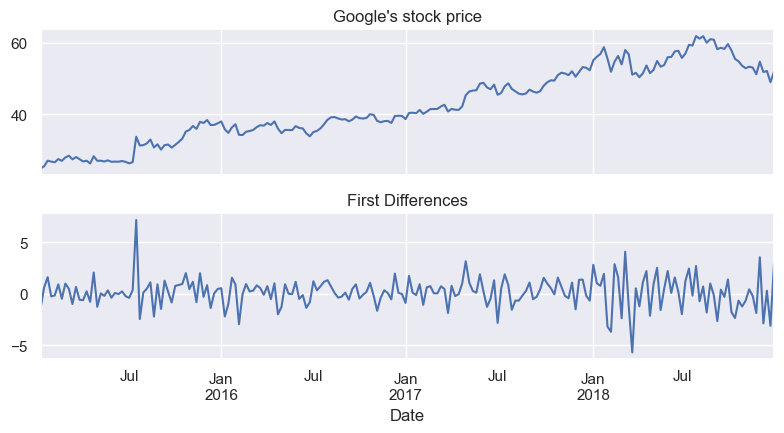

In [4]:
goog_diff = goog.diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
goog.plot(title="Google's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')

plt.tight_layout()
plt.show()

3- Test the differenced series for stationary

ADF test statistic: -12.79 (p-val: 0.00)
KPSS test statistic: 0.08 (p-val: 0.10)


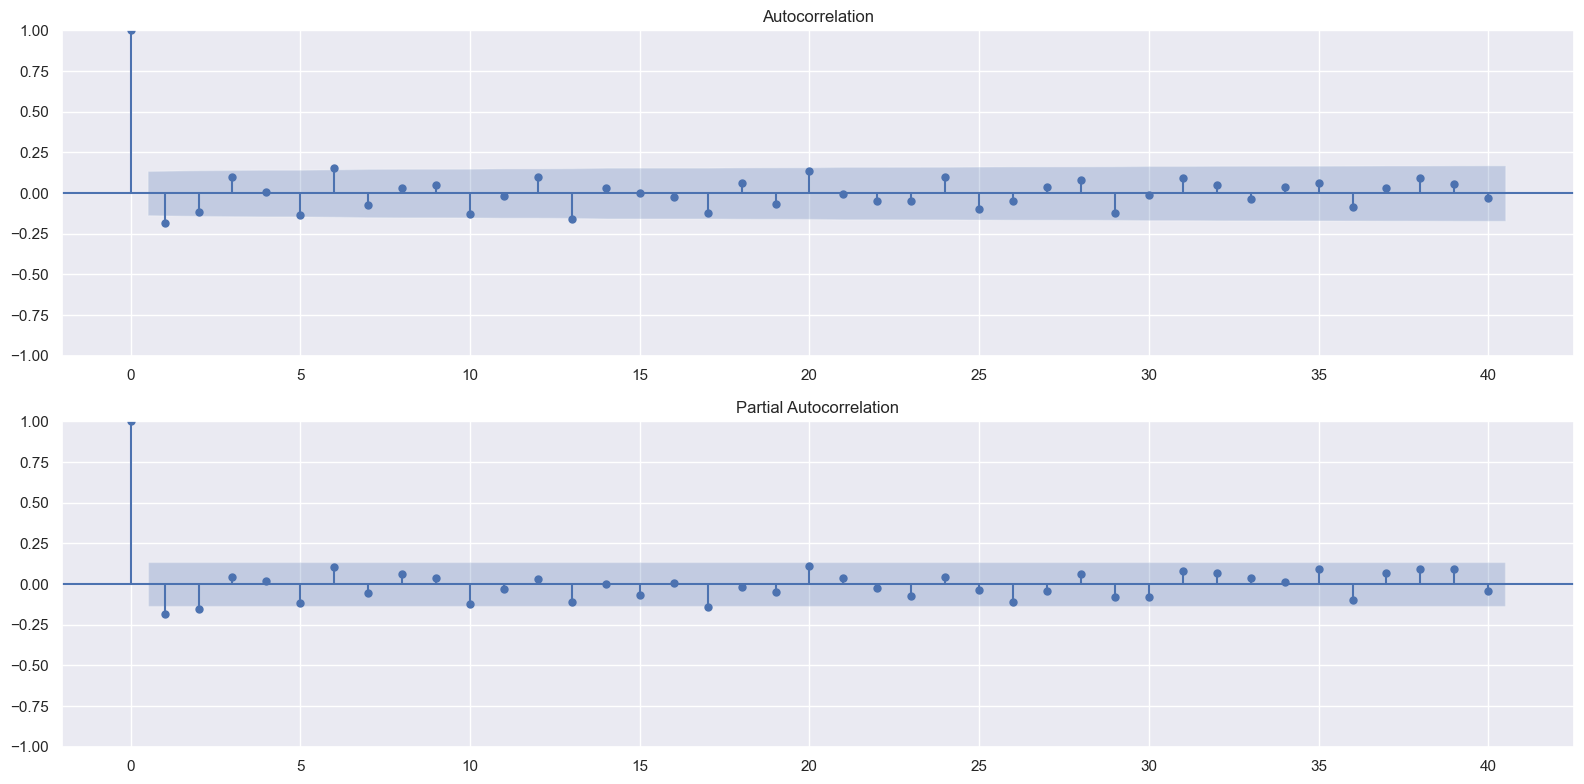

In [5]:
fig = test_autocorrelation(goog_diff)

plt.tight_layout()
plt.show()

4- Based on the results of the tests, specify the ARIMA model and fit it to the data

In [6]:
arima = ARIMA(goog, order=(2, 1, 1)).fit(start_params=[0, 0, 0, 1])
print(arima.summary())
#arima.summary()

                               SARIMAX Results                                
Dep. Variable:              adj_close   No. Observations:                  209
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -365.554
Date:                Mon, 12 Feb 2024   AIC                            739.108
Time:                        18:28:18   BIC                            752.458
Sample:                    01-04-2015   HQIC                           744.506
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4064      0.397     -1.025      0.306      -1.184       0.371
ar.L2         -0.1833      0.082     -2.241      0.025      -0.344      -0.023
ma.L1          0.2052      0.405      0.507      0.6

In [7]:
def arima_diagnostics(resids, n_lags=40):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
     Parameters
     ----------
     resids : np.array
     An array containing the residuals of a fitted model
     
     n_lags : int
     Number of lags for autocorrelation plot
     
     Returns
     -------
     fig : matplotlib.figure.Figure
     Created figure
     '''''
    
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')
    
    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.histplot(resids_nonmissing, kde=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
    
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')
    
    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')
    
    return fig

5- Test the residuals of the fitted ARIMA model

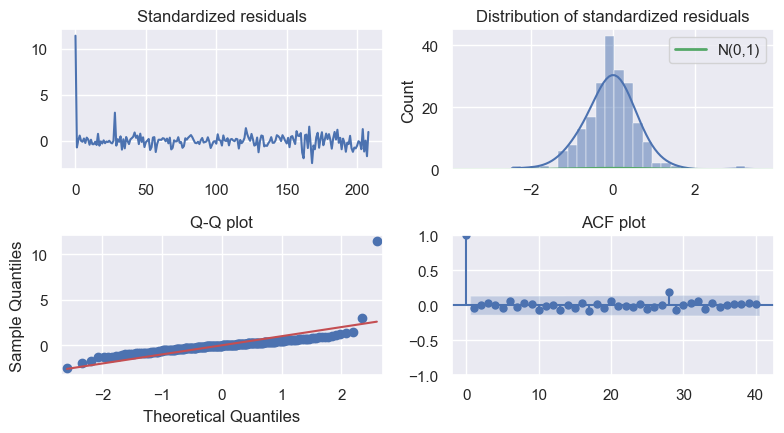

In [8]:
arima_diagnostics(arima.resid, 40)

plt.tight_layout()
plt.show()

8- Apply the Ljung-Box's test for no autocorrelation in the residuals and plot the results

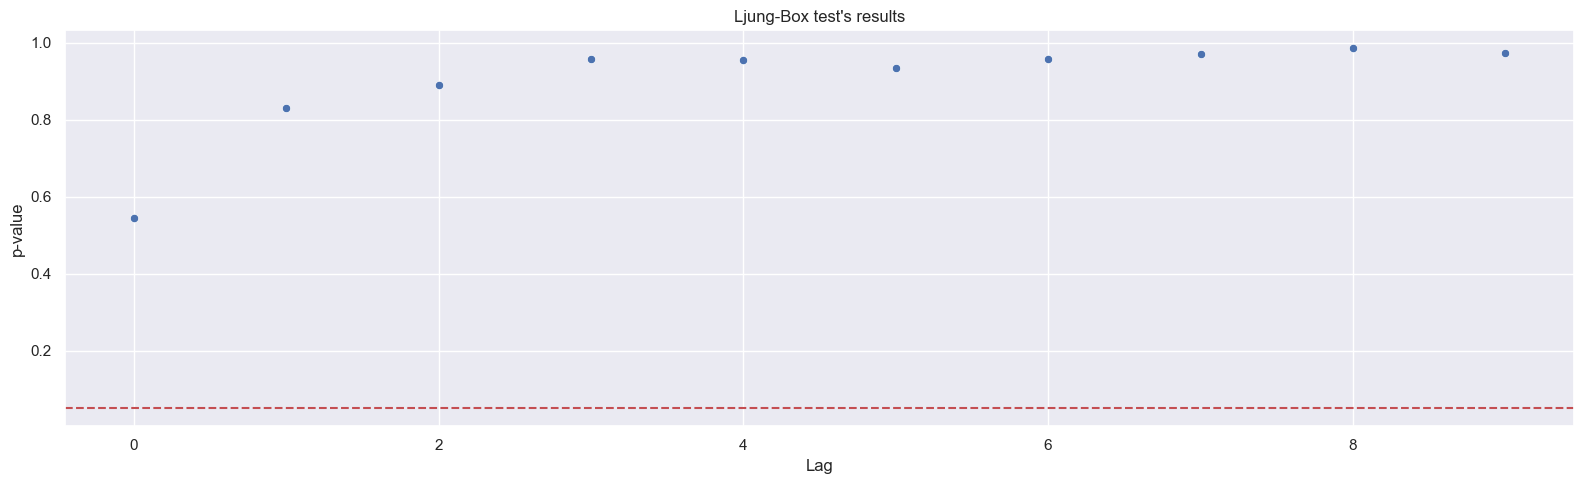

In [9]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results['lb_pvalue'])), y=ljung_box_results['lb_pvalue'], ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results", xlabel='Lag', ylabel='p-value')

plt.tight_layout()
plt.show()

### There's more

In [11]:
import pmdarima as pm

1- We run `auto_arima` with the majority of setting set to default values. We only exclude potential seasonality

In [14]:
auto_arima = pm.auto_arima(goog, error_action='ignore', suppress_warnings=True, seasonal=False)
#auto_arima.summary()
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -365.637
Date:                Mon, 12 Feb 2024   AIC                            737.273
Time:                        18:32:16   BIC                            747.286
Sample:                    01-04-2015   HQIC                           741.322
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1228      0.075      1.648      0.099      -0.023       0.269
ma.L1         -0.2376      0.070     -3.417      0.001      -0.374      -0.101
sigma2         1.9691      0.113     17.487      0.0

In [15]:
auto_arima = pm.auto_arima(goog, error_action='ignore', suppress_warnings=True, seasonal=False,
                            stepwise=False, approximation=False, n_jobs=-1)
#auto_rima.summary()
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -359.586
Date:                Mon, 12 Feb 2024   AIC                            733.173
Time:                        18:36:53   BIC                            756.535
Sample:                    01-04-2015   HQIC                           742.619
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4976      0.313      1.592      0.111      -0.115       1.110
ar.L1         -1.5445      0.138    -11.208      0.000      -1.815      -1.274
ar.L2         -1.1844      0.137     -8.622      0.0